# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [15]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [17]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float64) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float64) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=20000, max_test=3000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [18]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

check_layer_gradient(ReLULayer(), X)

[[ 1.  -0.   3. ]
 [-0.   2.   0.1]]
Gradient check passed!


True

А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [19]:
# TODO: Implement FullyConnected layer forward and backward methods
check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

[[ 0.00630943 -0.00364082  0.00395189 -0.0018699 ]
 [-0.00375565  0.00117379  0.00329714  0.00073376]]
Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [20]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])
print(loss)
# TODO Now implement backward pass and aggregate all of the params
#check_model_gradient(model, train_X[:2], train_y[:2])

2.303725438787228


Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [21]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)
print(loss_with_reg)
#check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

2.34987643191182


Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [22]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

3  out of  30


0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [23]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

1889  out of  19000
100  out of  1000
Loss: 2.302585, Train accuracy: 0.099421, val accuracy: 0.100000
1889  out of  19000
100  out of  1000
Loss: 2.302585, Train accuracy: 0.099421, val accuracy: 0.100000
1889  out of  19000
100  out of  1000
Loss: 2.302585, Train accuracy: 0.099421, val accuracy: 0.100000
1889  out of  19000
100  out of  1000
Loss: 2.302585, Train accuracy: 0.099421, val accuracy: 0.100000
1889  out of  19000
100  out of  1000
Loss: 2.302585, Train accuracy: 0.099421, val accuracy: 0.100000
1889  out of  19000
100  out of  1000
Loss: 2.302585, Train accuracy: 0.099421, val accuracy: 0.100000
1889  out of  19000
100  out of  1000
Loss: 2.302585, Train accuracy: 0.099421, val accuracy: 0.100000
1889  out of  19000
100  out of  1000
Loss: 2.302585, Train accuracy: 0.099421, val accuracy: 0.100000
1889  out of  19000
100  out of  1000
Loss: 2.302585, Train accuracy: 0.099421, val accuracy: 0.100000
1889  out of  19000
100  out of  1000
Loss: 2.302585, Train accuracy: 0.0

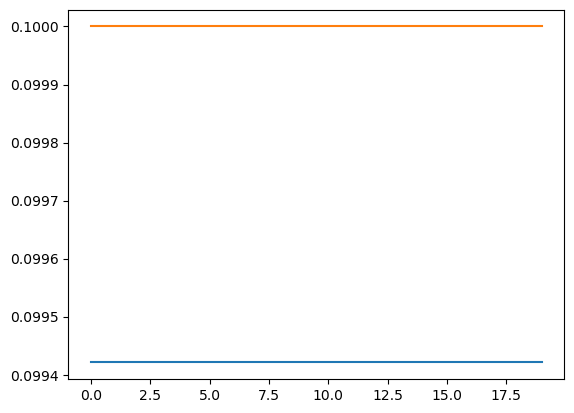

In [24]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [25]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

1850  out of  19000
94  out of  1000
Loss: 2.304894, Train accuracy: 0.097368, val accuracy: 0.094000
1920  out of  19000
94  out of  1000
Loss: 2.302936, Train accuracy: 0.101053, val accuracy: 0.094000
1903  out of  19000
97  out of  1000
Loss: 2.302640, Train accuracy: 0.100158, val accuracy: 0.097000
1891  out of  19000
100  out of  1000
Loss: 2.302594, Train accuracy: 0.099526, val accuracy: 0.100000
1811  out of  19000
105  out of  1000
Loss: 2.302586, Train accuracy: 0.095316, val accuracy: 0.105000
1869  out of  19000
109  out of  1000
Loss: 2.302585, Train accuracy: 0.098368, val accuracy: 0.109000
1981  out of  19000
116  out of  1000
Loss: 2.302585, Train accuracy: 0.104263, val accuracy: 0.116000
2467  out of  19000
132  out of  1000
Loss: 2.302585, Train accuracy: 0.129842, val accuracy: 0.132000
2749  out of  19000
154  out of  1000
Loss: 2.302585, Train accuracy: 0.144684, val accuracy: 0.154000
2875  out of  19000
157  out of  1000
Loss: 2.302585, Train accuracy: 0.1513

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [26]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

1995  out of  19000
112  out of  1000
Loss: 2.315327, Train accuracy: 0.105000, val accuracy: 0.112000
2006  out of  19000
113  out of  1000
Loss: 2.313144, Train accuracy: 0.105579, val accuracy: 0.113000
1971  out of  19000
111  out of  1000
Loss: 2.311323, Train accuracy: 0.103737, val accuracy: 0.111000
1967  out of  19000
113  out of  1000
Loss: 2.309860, Train accuracy: 0.103526, val accuracy: 0.113000
1969  out of  19000
111  out of  1000
Loss: 2.308642, Train accuracy: 0.103632, val accuracy: 0.111000
1962  out of  19000
109  out of  1000
Loss: 2.307647, Train accuracy: 0.103263, val accuracy: 0.109000
1977  out of  19000
109  out of  1000
Loss: 2.306815, Train accuracy: 0.104053, val accuracy: 0.109000
1983  out of  19000
110  out of  1000
Loss: 2.306127, Train accuracy: 0.104368, val accuracy: 0.110000
1982  out of  19000
109  out of  1000
Loss: 2.305562, Train accuracy: 0.104316, val accuracy: 0.109000
1969  out of  19000
111  out of  1000
Loss: 2.305085, Train accuracy: 0.1

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [28]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

4  out of  15
1  out of  15
Loss: 2.317792, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
1  out of  15
Loss: 2.339496, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
1  out of  15
Loss: 2.321597, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
1  out of  15
Loss: 2.328103, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
1  out of  15
Loss: 2.339123, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
1  out of  15
Loss: 2.270628, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
1  out of  15
Loss: 2.148682, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
1  out of  15
Loss: 2.159508, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
1  out of  15
Loss: 2.305963, Train accuracy: 0.266667, val accuracy: 0.066667
5  out of  15
1  out of  15
Loss: 2.354328, Train accuracy: 0.333333, val accuracy: 0.066667
6  out of  15
1  out of  15
Loss: 2.020195, Train accuracy: 0.400000, 

11  out of  15
1  out of  15
Loss: 2.660090, Train accuracy: 0.733333, val accuracy: 0.066667
14  out of  15
2  out of  15
Loss: 1.207942, Train accuracy: 0.933333, val accuracy: 0.133333
14  out of  15
2  out of  15
Loss: 1.051215, Train accuracy: 0.933333, val accuracy: 0.133333
15  out of  15
2  out of  15
Loss: 0.895221, Train accuracy: 1.000000, val accuracy: 0.133333
15  out of  15
2  out of  15
Loss: 0.803310, Train accuracy: 1.000000, val accuracy: 0.133333
14  out of  15
1  out of  15
Loss: 0.910655, Train accuracy: 0.933333, val accuracy: 0.066667
12  out of  15
1  out of  15
Loss: 1.406720, Train accuracy: 0.800000, val accuracy: 0.066667
15  out of  15
2  out of  15
Loss: 0.887780, Train accuracy: 1.000000, val accuracy: 0.133333
15  out of  15
2  out of  15
Loss: 0.998876, Train accuracy: 1.000000, val accuracy: 0.133333
15  out of  15
2  out of  15
Loss: 0.894191, Train accuracy: 1.000000, val accuracy: 0.133333
15  out of  15
2  out of  15
Loss: 0.893680, Train accuracy:

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [102]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=10)

loss_history, train_history, val_history = trainer.fit()

4  out of  15
1  out of  15
Loss: 2.308597, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
1  out of  15
Loss: 2.299427, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
1  out of  15
Loss: 2.276442, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
1  out of  15
Loss: 2.256336, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
1  out of  15
Loss: 2.270224, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
1  out of  15
Loss: 2.259679, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
1  out of  15
Loss: 2.221394, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
1  out of  15
Loss: 2.259634, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
1  out of  15
Loss: 2.218050, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
1  out of  15
Loss: 2.269472, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
1  out of  15
Loss: 2.171431, Train accuracy: 0.266667, 

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [29]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-3
reg_strength = 1e-2
learning_rate_decay = 0.998
hidden_layer_size = 128
num_epochs = 300
batch_size = 128

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = reg_strength)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=learning_rates, num_epochs=num_epochs, batch_size=batch_size, learning_rate_decay = learning_rate_decay)

loss_history, train_history, val_history = trainer.fit()
#print('best validation accuracy achieved: %f' % val_history)

3608  out of  19000
216  out of  1000
Loss: 2.287213, Train accuracy: 0.189895, val accuracy: 0.216000
3608  out of  19000
216  out of  1000
Loss: 2.265946, Train accuracy: 0.189895, val accuracy: 0.216000
3608  out of  19000
216  out of  1000
Loss: 2.279374, Train accuracy: 0.189895, val accuracy: 0.216000
3608  out of  19000
216  out of  1000
Loss: 2.291439, Train accuracy: 0.189895, val accuracy: 0.216000
3608  out of  19000
216  out of  1000
Loss: 2.261692, Train accuracy: 0.189895, val accuracy: 0.216000
3608  out of  19000
216  out of  1000
Loss: 2.216789, Train accuracy: 0.189895, val accuracy: 0.216000
3608  out of  19000
216  out of  1000
Loss: 2.279318, Train accuracy: 0.189895, val accuracy: 0.216000
3608  out of  19000
216  out of  1000
Loss: 2.242851, Train accuracy: 0.189895, val accuracy: 0.216000
3608  out of  19000
216  out of  1000
Loss: 2.281215, Train accuracy: 0.189895, val accuracy: 0.216000
3608  out of  19000
216  out of  1000
Loss: 2.297226, Train accuracy: 0.1

9410  out of  19000
492  out of  1000
Loss: 1.649662, Train accuracy: 0.495263, val accuracy: 0.492000
9503  out of  19000
500  out of  1000
Loss: 1.600311, Train accuracy: 0.500158, val accuracy: 0.500000
9593  out of  19000
502  out of  1000
Loss: 1.664748, Train accuracy: 0.504895, val accuracy: 0.502000
9694  out of  19000
512  out of  1000
Loss: 1.512087, Train accuracy: 0.510211, val accuracy: 0.512000
9725  out of  19000
515  out of  1000
Loss: 1.553396, Train accuracy: 0.511842, val accuracy: 0.515000
9831  out of  19000
522  out of  1000
Loss: 1.661102, Train accuracy: 0.517421, val accuracy: 0.522000
9868  out of  19000
520  out of  1000
Loss: 1.753549, Train accuracy: 0.519368, val accuracy: 0.520000
9933  out of  19000
525  out of  1000
Loss: 1.644047, Train accuracy: 0.522789, val accuracy: 0.525000
10037  out of  19000
533  out of  1000
Loss: 1.617922, Train accuracy: 0.528263, val accuracy: 0.533000
10096  out of  19000
531  out of  1000
Loss: 1.741563, Train accuracy: 0

12621  out of  19000
665  out of  1000
Loss: 1.437185, Train accuracy: 0.664263, val accuracy: 0.665000
12624  out of  19000
662  out of  1000
Loss: 1.366773, Train accuracy: 0.664421, val accuracy: 0.662000
12640  out of  19000
667  out of  1000
Loss: 1.625653, Train accuracy: 0.665263, val accuracy: 0.667000
12677  out of  19000
668  out of  1000
Loss: 1.248213, Train accuracy: 0.667211, val accuracy: 0.668000
12673  out of  19000
667  out of  1000
Loss: 1.571375, Train accuracy: 0.667000, val accuracy: 0.667000
12682  out of  19000
670  out of  1000
Loss: 1.610097, Train accuracy: 0.667474, val accuracy: 0.670000
12709  out of  19000
671  out of  1000
Loss: 1.663528, Train accuracy: 0.668895, val accuracy: 0.671000
12733  out of  19000
672  out of  1000
Loss: 1.726824, Train accuracy: 0.670158, val accuracy: 0.672000
12723  out of  19000
669  out of  1000
Loss: 1.503748, Train accuracy: 0.669632, val accuracy: 0.669000
12739  out of  19000
668  out of  1000
Loss: 1.587582, Train acc

13337  out of  19000
694  out of  1000
Loss: 1.333144, Train accuracy: 0.701947, val accuracy: 0.694000
13368  out of  19000
703  out of  1000
Loss: 1.341909, Train accuracy: 0.703579, val accuracy: 0.703000
13336  out of  19000
698  out of  1000
Loss: 1.396439, Train accuracy: 0.701895, val accuracy: 0.698000
13344  out of  19000
697  out of  1000
Loss: 1.318521, Train accuracy: 0.702316, val accuracy: 0.697000
13371  out of  19000
696  out of  1000
Loss: 1.241309, Train accuracy: 0.703737, val accuracy: 0.696000
13362  out of  19000
701  out of  1000
Loss: 1.474039, Train accuracy: 0.703263, val accuracy: 0.701000
13364  out of  19000
701  out of  1000
Loss: 1.345138, Train accuracy: 0.703368, val accuracy: 0.701000
13382  out of  19000
701  out of  1000
Loss: 1.280773, Train accuracy: 0.704316, val accuracy: 0.701000
13392  out of  19000
698  out of  1000
Loss: 1.313956, Train accuracy: 0.704842, val accuracy: 0.698000
13399  out of  19000
698  out of  1000
Loss: 1.411650, Train acc

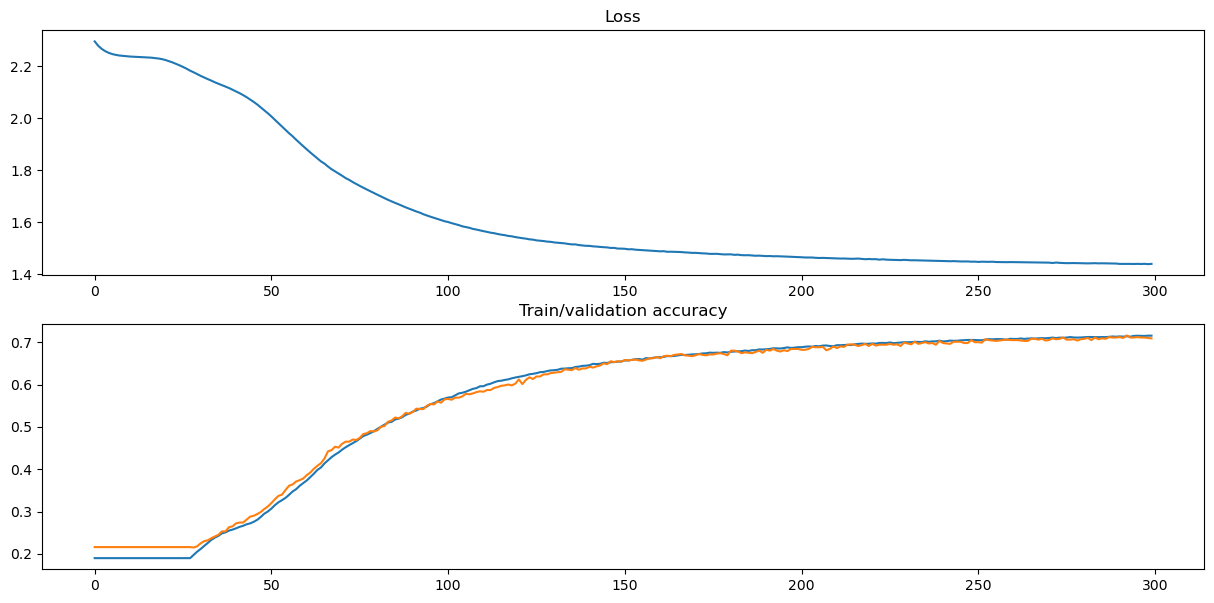

In [30]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [ ]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))